In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
text_classification = pd.read_csv('/content/topic_classification_complete_process1.csv')
text_classification

,label,content
0,Emotion,Im struggling to understand how I feel about s...
1,Financial,NEW: Modis promise to ban plastic straws this ...
2,Financial,SURVEY: Middle-Income Americans Spending Less ...
3,Financial,WATCH: Wall Street ended lower after bank stoc...
4,Financial,Someone selling a ton of $SE puts to open Sep ...
...,...,...
136798,Health,Ehlers-Danlos syndrome (EDS) is a group of inh...
136799,Emotion,i feel tortured being a person because no one ...
136800,Health,Aicardi-Goutieres syndrome is an inherited con...
136801,Emotion,i feel really successful for the fact that i r...


# **Tarea 2a y b**: Realiza una descripción del dataset. Analiza los posibles problemas, realiza el preprocesamiento necesario y los pasos necesarios para generar una o varias representaciones de los textos mediante características que puedan ser utilizadas para entrenar algoritmos de clasificación. Si es necesario, considera una porción representativa más pequeña del dataset para poder entrenar un clasificador.

Nos encontramos ante un dataset de únicamente dos columnas, la primera "label" nos indica la etiqueta representativa de lo que trata la siguiente columna "content", esta segunda columna se trata de frases en inglés de distintos temas (los de la primera columna) tales como ciencia, deporte, política, economía...

In [ ]:
text_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136803 entries, 0 to 136802
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    136803 non-null  object
 1   content  136798 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [ ]:
text_classification.describe()

,label,content
count,136803,136798
unique,6,136111
top,Politics,This condition is inherited in an autosomal re...
freq,37797,348


Podemos observar como es un dataset de únicamente 6 temas, en el que la Política es el que más se repite.
Además, las frases son muy diversas, apenas coindicen, aunque esta que se muestra aparece un total de 348 veces.

In [ ]:
text_classification.dtypes

label      object
content    object
dtype: object

In [ ]:
text_classification['label'].value_counts()

Politics     37797
Health       36952
Emotion      28362
Financial    22981
Sport         6077
Science       4634
Name: label, dtype: int64

Como se puede observar, los datos de este dataset están un poco desbalanceados, tenemos 4 de 6 características con un número semejante de datos, sin embargo, de ciencia y deporte apenas hay, esto supone un problema a la hora de evaluar el modelo puesto que puede afectar a la capacidad para generalizar a la clase menos representada.

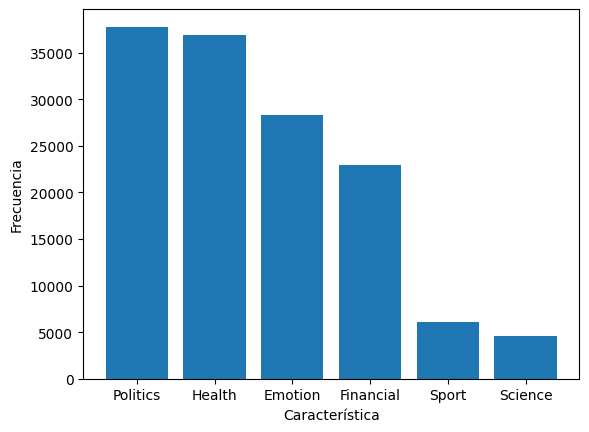

In [ ]:
categoria_counts = text_classification['label'].value_counts()

plt.bar(categoria_counts.index, categoria_counts)
plt.xlabel('Característica')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
text_classification.isnull().sum()

label      0
content    5
dtype: int64

Hay muy pocos valores nulos, los cuales eliminaremos

In [ ]:
text_classification.dropna(inplace = True)

In [ ]:
text_classification.isnull().sum()

label      0
content    0
dtype: int64

Este dataset es muy particular ya que todos los que habíamos tratado hasta ahora era con números, sin embargo, este es solo texto y a la hora de trabajar con texto en modelos suele dar muchas complicaciones y problemas, por lo que trataremos de solucionar todo aquello que parezca que nos pueda complicar.

Ya que se trata de clasificar en distintas etiquetas los textos, eso significa que las palabras cobran una gran importancia, así como el número de apariciones, etc.

Es por ello que pasaremos todas las letras a minúsculas, porque una misma palabra puede aparecer como "virus" y "Virus" y en realidad se trata de la misma, sin embargo, al tener una mayúscula se tratan como diferentes, de ahí la importancia de trabajar con todo igual

In [ ]:
text_classification['content'] = text_classification['content'].str.lower()

In [ ]:
text_classification

,label,content
0,Emotion,im struggling to understand how i feel about s...
1,Financial,new: modis promise to ban plastic straws this ...
2,Financial,survey: middle-income americans spending less ...
3,Financial,watch: wall street ended lower after bank stoc...
4,Financial,someone selling a ton of $se puts to open sep ...
...,...,...
136798,Health,ehlers-danlos syndrome (eds) is a group of inh...
136799,Emotion,i feel tortured being a person because no one ...
136800,Health,aicardi-goutieres syndrome is an inherited con...
136801,Emotion,i feel really successful for the fact that i r...


In [ ]:
text_classification['content'][2]

'survey: middle-income americans spending less amid recession concerns https://t.co/tryqhdjdnd https://t.co/7lanzxxrta'

Observando el dataset, nos damos cuenta que algunos textos contienen urls, esto no nos aporta nada de información y de hecho lo único que nos hace es complicarnos más la vida, por lo que eliminaremos de las filas todas las urls.

In [ ]:
patron_url = r'https?://\S+|www\.\S+'
df_urls = text_classification[text_classification['content'].str.contains(patron_url, na=False)]


In [ ]:
df_urls       #observamos como 15290 filas del dataset tenían urls, es decir, no eran pocas

,label,content
1,Financial,new: modis promise to ban plastic straws this ...
2,Financial,survey: middle-income americans spending less ...
3,Financial,watch: wall street ended lower after bank stoc...
14,Financial,liberty station podcast joins salem podcast ne...
20,Financial,abb to spin off turbocharging business to shar...
...,...,...
136764,Financial,$sky: skyline champion to acquire the assets a...
136766,Financial,$wing - resting after a big runup https://t.co...
136773,Financial,pakistan plans to cut fuel costs to pass on th...
136782,Financial,canadian bond and index update @mtlexchange ht...


In [ ]:
text_classification['content'] = text_classification['content'].str.replace(patron_url, '', regex=True)
text_classification['content'] = text_classification['content'].str.strip()


In [ ]:
contiene_url = text_classification['content'].str.contains(patron_url).any()

if contiene_url:
    print("Al menos una fila contiene una URL en la columna 'content'.")
else:
    print("No se encontraron URLs en la columna 'content'.")

No se encontraron URLs en la columna 'content'.


In [ ]:
text_classification['content'][2]

'survey: middle-income americans spending less amid recession concerns'

También, vamos a eliminar todo signo de puntuación, a nosotros los humanos nos ayuda a entender el significado de las frases dependiendo de donde y cómo se coloquen, pero a los modelos no, por lo que nos deshacemos de ellos.

In [ ]:
def eliminar_puntos(text):
  return re.sub('[%s]' % re.escape(string.punctuation), '', text)

text_classification['content'] = text_classification['content'].apply(eliminar_puntos)

In [ ]:
text_classification[:5]

,label,content
0,Emotion,im struggling to understand how i feel about s...
1,Financial,new modis promise to ban plastic straws this m...
2,Financial,survey middleincome americans spending less am...
3,Financial,watch wall street ended lower after bank stock...
4,Financial,someone selling a ton of se puts to open sep a...


Tratando de evitar problemas, decidimos eliminar los números de todas las filas. En un primer momento puede parecer que los números son de gran utilidad porque pueden aparecer en muchos textos "Financial" sin embargo, pueden aparecer en cualquiera ya sea indicando un año o cualquier otra cosa y en realidad, mucha información no aportan a la hora de tratar de clasificar un texto en una categoría u otra.

In [ ]:
def no_digits(text):
  return re.sub(r'\d', '', text)

text_classification['content'] = text_classification['content'].apply(no_digits)

Este término quizás no se conocía, pero las stopwords son palabras comunes que no contribuyen significativamente al significado de un texto, ya que aparecen de forma indiscriminada, ejemplos de ellas son las conjunciones, determinantes...

Es conveniente eliminarlas, de esta manera reducimos la dimensionalidad y mejora el rendimiento de los modelos de PLN.

In [ ]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('punkt')
def eliminar_stopwords(texto):
  words = nltk.word_tokenize(texto)
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

text_classification['content'] = text_classification['content'].apply(eliminar_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
text_classification

,label,content
0,Emotion,im struggling understand feel someone want opi...
1,Financial,new modis promise ban plastic straws month put...
2,Financial,survey middleincome americans spending less am...
3,Financial,watch wall street ended lower bank stocks eras...
4,Financial,someone selling ton se puts open sep nov
...,...,...
136798,Health,ehlersdanlos syndrome eds group inherited diso...
136799,Emotion,feel tortured person one world even think im s...
136800,Health,aicardigoutieres syndrome inherited condition ...
136801,Emotion,feel really successful fact read series books ...


Ahora vamos a realizar la stemización, esto implica reducir las palabras a su raiz eliminando sufijos, prefijos, conjugaciones...

De esta manera, palabras como "hablar", "hablando", "hablador" que se refieren a lo mismo, son tomadas como distintas, es por ello, que se reduce a "habl" para no tener problemas.

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stemming(texto):
  words = nltk.word_tokenize(texto)
  stem_tokens = [stemmer.stem(word) for word in words]
  return ' '.join(stem_tokens)

text_classification['content'] = text_classification['content'].apply(stemming)


El problema de la stemización es que "habl" o "corr" no son palabras reales ni válidas en ningún idioma, por lo que usaremos la lematización, la cual se asegura de obtener una palabra que exista

Por ejemplo "mejor" lo sustituiría por "bueno" de esta manera se hace más preciso.

In [ ]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lematizacion(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

text_classification['content'] = text_classification['content'].apply(lematizacion)

[nltk_data] Downloading package wordnet to /root/nltk_data...


Tras esto, vamos a ver como de bien vamos, queremos observar características interesantes como cual es la frecuencia de ciertas palabras o cuales son las más frecuentes en cada texto, para así saber si lo que hemos estado haciendo sirve para algo

In [ ]:
from nltk.stem import PorterStemmer
from collections import Counter

stemmer = PorterStemmer()

text_classification['cleantext_stemmed'] = text_classification['content'].apply(lambda x: [stemmer.stem(word) for word in x.split()])

word_frequencies_by_label = {}

for index, row in text_classification.iterrows():
    label = row['label']
    stem_tokens = row['cleantext_stemmed']

    if label not in word_frequencies_by_label:
        word_frequencies_by_label[label] = Counter(stem_tokens)
    else:
        word_frequencies_by_label[label] += Counter(stem_tokens)

for label, frequencies in word_frequencies_by_label.items():
    print(f"Label: {label}")
    print(frequencies.most_common(10))
    print("\n")


Label: Emotion
[('feel', 22752), ('like', 5558), ('im', 4533), ('love', 2765), ('know', 2499), ('get', 2486), ('want', 2462), ('time', 2342), ('go', 2182), ('realli', 2004)]


Label: Financial
[('u', 1806), ('market', 1799), ('new', 1733), ('busi', 1687), ('stock', 1437), ('year', 1310), ('compani', 1247), ('say', 1197), ('bank', 1108), ('economi', 1066)]


Label: Politics
[('trump', 11371), ('presid', 3726), ('say', 3687), ('donald', 3388), ('republican', 2879), ('u', 2715), ('state', 2675), ('new', 2647), ('democrat', 2592), ('clinton', 2459)]


Label: Sport
[('game', 3849), ('said', 3254), ('team', 2994), ('play', 2805), ('player', 2548), ('season', 2337), ('one', 2310), ('year', 2296), ('go', 2100), ('win', 2072)]


Label: Health
[('symptom', 31400), ('may', 29871), ('peopl', 22369), ('sign', 19933), ('condit', 17276), ('caus', 16375), ('cancer', 15724), ('treatment', 14974), ('cell', 14969), ('diseas', 14902)]


Label: Science
[('new', 564), ('studi', 432), ('research', 376), ('sc

Como podemos observar, tiene muy buena pinta, no hace falta ser un modelo para darse cuenta que si en los textos marcados como "Financial" las palabras que más se repiten es "market", "busi" (de business) o "bank" significa que las cosas se están haciendo bien y más adelante el modelo hará un buen trabajo.

Sin embargo, como dijimos al principio de este trabajo, la cantidad de datos (texto) que había de determinados temas estaba totalmente desbalanceada, por lo que lo que haremos es un undersammpling, de esta manera obtendremos más o menos la misma cantidad de textos de unos temas que otros.

In [ ]:
X = text_classification['content']
y = text_classification['label']

from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = under_sampler.fit_resample(X.values.reshape(-1, 1), y)

text_classification_resampled = pd.DataFrame({'texto': X_resampled.flatten(), 'label': y_resampled})

text_classification_resampled

,texto,label
0,extremely indign,Emotion
1,end summer,Emotion
2,feel successful make sense,Emotion
3,late night opinion statementlisten ca want see...,Emotion
4,feel love sweet little arm wrapped around leg ...,Emotion
...,...,...
27799,tournament start coincides eid alfitr end holy...,Sport
27800,game decision made olympicsus basketball team ...,Sport
27801,former athlete stay close root following bigge...,Sport
27802,team usa goalie criticized sweden olympic quar...,Sport


In [ ]:
text_classification_resampled['label'].value_counts()

Emotion      4634
Financial    4634
Health       4634
Politics     4634
Science      4634
Sport        4634
Name: label, dtype: int64

Ya estamos apunto de empezar a trabajar con los modelos, sin embargo, queda algo muy importante y es que las palabras han de ser convertidas en números para que los modelos puedan utilizarlas, por lo que lo primero que hacemos de manera muy sencilla es asignar a cada "label" que teníamos un número. De esta manera si un texto es de política a partir de ahora será clasificado en el grupo 3.

In [ ]:
categoric_label = {'Emotion': 0,
                   'Financial': 1,
                   'Health': 2,
                   'Politics': 3,
                   'Science': 4,
                   'Sport' : 5}

text_classification_resampled['label'] = text_classification_resampled['label'].replace(categoric_label)

In [ ]:
text_classification_resampled

,texto,label
0,extremely indign,0
1,end summer,0
2,feel successful make sense,0
3,late night opinion statementlisten ca want see...,0
4,feel love sweet little arm wrapped around leg ...,0
...,...,...
27799,tournament start coincides eid alfitr end holy...,5
27800,game decision made olympicsus basketball team ...,5
27801,former athlete stay close root following bigge...,5
27802,team usa goalie criticized sweden olympic quar...,5


Por último, como hemos dicho, los textos han de quedar como una representación numérica para que pueda ser utilizado en modelos, el "label" era sencillo ya que solo eran clases las cuales asignar un único número, sin embargo, con los textos se nos complica ya que son cadenas de muchas palabras las cuales no le puedes asignar a cada una un número puesto que idiomas como el inglés por ejemplo, tienen más de 250k palabras.

Lo que se hace en estas situaciones es vectorizar la cadena de texto en la que cada palabra se representa como un vector de ceros y uno, con el cual es mucho más fácil trabajar para los modelos.

Hay distintas formas de realizar esta tarea, una de ellas es usando el Word2Vec, sin embargo hemos visto una función en sklearn que es TfidfVectorizer, la cual  transforma cada fila de texto en una matriz.

La representación TF-IDF tiene de especial que asigna un número a cada palabra en función de cuantas veces aparezca en el texto y como de rara sea encontrarla en el resto de textos, esto ayuda a destacar ciertas palabras clave que son distintivas y nos ayudan a clasificar el texto.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = text_classification_resampled['texto']

tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(X)

X_tfidf


<27804x62003 sparse matrix of type '<class 'numpy.float64'>'
	with 659036 stored elements in Compressed Sparse Row format>

In [ ]:
y = text_classification_resampled['label']

# **Tarea 2c:** Entrega y evalúa al menos 2 algoritmos de clasificación de los vistos en clase para clasificar el tópico de los textos. Utiliza las métricas adecuadas para evaluar cada algoritmo mediante conjuntos de entrenamiento y test.

##MLP

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42, test_size = 0.2)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, batch_size=64)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred)
precision_mlp = precision_score(y_test, y_pred, average='micro')

print('Accuracy con tres capas ocultas de 128, 64, 32 neuronas : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Accuracy con tres capas ocultas de 128, 64, 32 neuronas : 0.7925


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       916
           1       0.76      0.81      0.78       955
           2       0.81      0.73      0.77       953
           3       0.84      0.76      0.80       909
           4       0.70      0.72      0.71       919
           5       0.88      0.85      0.86       909

    accuracy                           0.79      5561
   macro avg       0.80      0.79      0.79      5561
weighted avg       0.79      0.79      0.79      5561



Ya que se trata de un dataset grande con muchos datos, hemos utilizado una red neuronal no muy grande, pero de un tamaño decente que no tarde mucho en procesar ni se produzca overfitting y a la vez no queríamos un modelo básico, porque no iba a poder hacer bien la clasificación con tantos datos.

Desde luego, los resultados obtenidos, que rondan el 0.8 son bastante buenos.

## SVC

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state = 42, test_size = 0.2)

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=10, random_state=42)
svc.fit(X_train, y_train)

y_pred = list(svc.predict(X_test))
accuracy_svc = accuracy_score(y_test, y_pred)
precision_svc = precision_score(y_test, y_pred, average='micro')
print('Accuracy SVC con kernel rbf y c=10: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy SVC con kernel rbf y c=10: 0.8392


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       916
           1       0.83      0.82      0.83       955
           2       0.86      0.79      0.82       953
           3       0.83      0.85      0.84       909
           4       0.71      0.82      0.76       919
           5       0.92      0.87      0.89       909

    accuracy                           0.84      5561
   macro avg       0.84      0.84      0.84      5561
weighted avg       0.84      0.84      0.84      5561



Utilizando SVC llegamos a mejorar los resultados de la red neuronal con bastante solvencia, hay algunas categorías en las que se clasifica por encima del 0.9, esto se puede considerar unos resultados muy buenos.

##RandomForest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.33, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, max_depth=20)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
accuracy_rfc = accuracy_score(y_test, y_pred)
precision_rfc = precision_score(y_test, y_pred, average='micro')
print('Accuracy con 500 árboles y profundidad máxima de 20: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy con 500 árboles y profundidad máxima de 20: 0.7407


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1543
           1       0.70      0.76      0.73      1531
           2       0.87      0.60      0.71      1533
           3       0.82      0.74      0.78      1534
           4       0.54      0.79      0.64      1518
           5       0.89      0.71      0.79      1517

    accuracy                           0.74      9176
   macro avg       0.77      0.74      0.74      9176
weighted avg       0.77      0.74      0.74      9176



Por último, el RandomForest es el modelo que peor clasifica de los 3 que hemos probado, especialmente la precison en la clase 4 (ciencia) es la que destaca por sus peores resultados.

## Conclusión

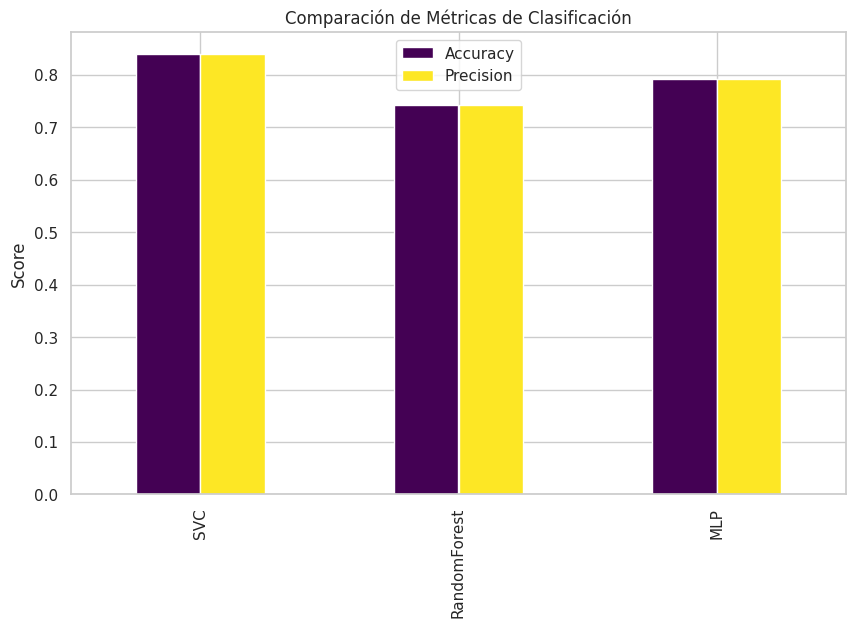

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics_data = {
    'Accuracy': [accuracy_svc, accuracy_rfc, accuracy_mlp],
    'Precision': [precision_svc, precision_rfc, precision_mlp],
}

metrics_df = pd.DataFrame(metrics_data, index=['SVC', 'RandomForest', 'MLP'])

sns.set(style="whitegrid")
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparación de Métricas de Clasificación')
plt.ylabel('Score')
plt.show()


Como se puede observar en las gráficas, los modelos han hecho muy buen trabajo a la hora de clasificar en general los textos. Si es verdad, que en textos sobre ciencia solían tener más problemas para clasificarlos correctamente, quizás porque hay algunos textos de temas como la salud que comparten palabras y hacen que los modelos se equivoquen a la hora de clasificar.

Aún así, se aprecian buenos resultados.